# 课程学习(Curriculum Learning)

### 1. 课程难度的定义
课程学习的核心是“难度”，通常用**模型在样本上的损失**表示某一样本/任务在当前阶段的难度：
$$
d_t(z) = \ell(f_{\theta_t}, z) \tag{8.1}
$$
其中：
- $ t $：训练时刻（课程阶段）；
- $ z $：样本/任务；
- $ f_{\theta_t} $：时刻 $ t $ 的模型（参数为 $ \theta_t $）；
- $ \ell(\cdot) $：损失函数（衡量模型在该样本上的表现，损失越高则难度越大）。


### 2. 课程难度的统计量（平均难度）
描述当前课程的整体难度，用**样本分布上的平均损失**表示：
$$
\bar{d}_t = \mathbb{E}_{z \sim p_t} \left[ d_t(z) \right] = \mathbb{E}_{z \sim p_t} \left[ \ell(f_{\theta_t}, z) \right]\tag{8.2}
$$
其中 $ p_t $ 是时刻 $ t $ 的样本/任务分布（课程的“内容集合”）。


### 3. 课程分布的调整（主动控制难度）
课程学习的核心动作是**动态调整样本分布 $ p_t $**，以控制难度的变化趋势。用分布的更新公式表示：
$$
p_{t+1} = \text{CurriculumUpdate}\left(p_t, \left\{ d_t(z) \right\}_{z \in \mathcal{Z}} \right)\tag{8.3}
$$
其中：
- $ \mathcal{Z} $ 是所有样本/任务的集合；
- $ \text{CurriculumUpdate} $ 是课程调整规则（比如：若当前平均难度 $ \bar{d}_t < \epsilon $，则增加难样本的占比；若 $ \bar{d}_t > \delta $，则增加简单样本的占比）。

这个规则的核心逻辑是让课程难度始终匹配模型当前的学习能力，避免“太简单学不到东西”或“太难学不会”的问题，本质是模仿人类“循序渐进”的学习节奏：

- 场景：模型已经轻松掌握当前课程的内容（平均损失很小），继续学简单样本会“吃不饱”，无法提升能力。
- 目的：通过增加难样本的占比，提升课程的整体难度，给模型设置新的学习目标，推动模型进一步优化（比如从“会做基础题”过渡到“会做拔高题”）。


- 场景：模型在当前课程中表现很差（平均损失太大），说明内容超出了模型的现有能力，继续硬学难样本会导致“挫败感”（比如训练不收敛、学不会核心规律）。
- 目的：通过增加简单样本的占比，降低课程的整体难度，让模型重新巩固基础、积累信心，等能力提升后再挑战难内容（比如从“做不会的难题”退回到“复习基础题”）。


简单说，这个规则是在动态维持“课程难度”和“模型能力”的平衡：既不让课程太简单（浪费训练资源），也不让课程太难（打击模型学习效率），最终让模型以最高效的节奏提升能力。



### 4. 难度的动态变化（被动+主动）
结合“模型学习带来的难度自然变化”和“课程分布调整带来的难度主动变化”，整体难度的变化可表示为：
$$
\bar{d}_{t+1} = \mathbb{E}_{z \sim p_{t+1}} \left[ \ell(f_{\theta_{t+1}}, z) \right]\tag{8.4}
$$
其中：
- $ \theta_{t+1} $ 是模型学习后的参数；
- $ p_{t+1} $ 是调整后的课程分布。

这个公式里的被动+主动，是课程学习中难度变化的两个核心来源，二者共同决定了下一时刻课程的整体平均难度 $ \bar{d}_{t+1}$，我们可以拆解开来看：

1. 被动变化：模型自身学习带来的难度下降

这个变化的主体是模型参数 $ \theta $，和课程分布无关，是模型“自己学会了”导致的难度降低。
- 逻辑：在不调整样本分布 $ p_t $ 的情况下，模型通过训练更新参数（从 $ \theta_t $ 到 $ \theta_{t+1} $），对同一批样本的预测能力会提升，损失 $ \ell(f_{\theta}, z)$ 自然下降。
- 举例：模型一开始对“识别猫”的样本损失很高（难度大），训练一轮后参数更新，对这些猫样本的损失降低了——这个难度变化没有人为调整样本，是模型自己学出来的，所以叫被动变化。
- 对应公式部分：$ \ell(f_{\theta_{t+1}}, z) $ 中的 $ \theta_{t+1} $ 就是被动变化的核心。

2. 主动变化：课程分布调整带来的难度调控
这个变化的主体是课程设计者，是人为主动调整样本分布 $ p_t $ 来控制难度。
- 逻辑：我们根据当前的平均难度 $ \bar{d}_t $，主动改变样本被选中的概率（从 $ p_t $ 到 $ p_{t+1} $）——比如增加难样本权重让课程变难，或增加简单样本权重让课程变简单。
- 举例：模型已经能轻松识别猫（平均损失低），我们主动加入“模糊的猫、遮挡的猫”这些难样本，让新的样本分布 $ p_{t+1} $ 包含更多难例——这个难度变化是人为主动加进去的，所以叫主动变化。
- 对应公式部分：$ \mathbb{E}_{z \sim p_{t+1}}[\cdot] $ 中的 $ p_{t+1} $ 就是主动变化的核心。

因此，$\bar{d}_{t+1} = \mathbb{E}_{z \sim p_{t+1}} \left[ \ell(f_{\theta_{t+1}}, z) \right] $ 这个公式，同时包含了两个维度的变化：
-  模型被动学习：$ \theta_t \to \theta_{t+1}$，让单个样本的损失降低；
-  课程主动调控：$ p_t \to p_{t+1} $，让样本组合的难度发生变化。

最终的 $ \bar{d}_{t+1} $ 就是这两种变化叠加后的结果。

比如：
- 模型被动学习让猫样本的损失下降了10%（难度降低）；
- 我们主动加入难样本，让课程的整体难度上升了5%；
- 最终 $ \bar{d}_{t+1} = $ 原来的难度 - 10% + 5%，实现了难度的平稳提升。



补充几个常见的课程调整规则的具体示例公式：

### 示例1：“易到难”的线性难度递增规则
核心逻辑：先让模型学简单样本，再逐步增加难样本的占比。
设样本 $ z $ 的“固有难度”为 $ \alpha(z) $（比如预先标注的难度等级），则时刻 $ t $ 样本 $ z $ 被选中的概率为：
$$
p_t(z) \propto \exp\left( -\frac{\alpha(z)}{\tau_t} \right)\tag{8.5}
$$
其中 $ \tau_t = \tau_0 + \gamma \cdot t $ 是“温度系数”（$ \tau_0>0 $ 是初始温度，$ \gamma>0 $ 是递增率）。
- $ t $ 较小时，$ \tau_t $ 小 → 难样本（$ \alpha(z) $ 大）的概率低，模型主要学简单样本；
- $ t $ 增大时，$ \tau_t $ 大 → 难样本的概率上升，课程逐渐变难。

**数值理解**：
公式 $ p_t(z) \propto \exp\left(-\frac{\alpha(z)}{\tau_t}\right) $ 表示样本$ z $ 的选中概率与指数项成正比。我们取两个样本对比：
- 简单样本 $ z_1 $：固有难度 $ \alpha_1 $（较小）
- 难样本 $ z_2 $：固有难度 $ \alpha_2 $（较大），且 $ \alpha_2 > \alpha_1 $

计算两者的概率比值（正比关系下，比值与常数无关）：
$$
\frac{p_t(z_2)}{p_t(z_1)} = \frac{\exp\left(-\frac{\alpha_2}{\tau_t}\right)}{\exp\left(-\frac{\alpha_1}{\tau_t}\right)} = \exp\left( \frac{\alpha_1 - \alpha_2}{\tau_t} \right)\tag{8.6}
$$
已知 $ \alpha_1 - \alpha_2 < 0 $，所以指数部分是负数。

接下来分析 $ \tau_t $ 增大时，这个比值的变化：
- 当 $ t $ 很小 → $ \tau_t $ 很小：指数部分 $ \frac{\alpha_1 - \alpha_2}{\tau_t} $ 的绝对值很大（负数），因此 $ \exp(\text{大负数}) \approx 0 $ → $ \frac{p_t(z_2)}{p_t(z_1)} \approx 0 $ → 难样本 $ z_2 $ 的概率远小于简单样本 $ z_1 $。
- 当 $ t $ 增大 → $ \tau_t $ 增大：指数部分 $ \frac{\alpha_1 - \alpha_2}{\tau_t} $ 的绝对值变小（负数趋近于0），因此 $ \exp(\text{接近0的负数}) $ 趋近于 $ \exp(0)=1$  → $ \frac{p_t(z_2)}{p_t(z_1)} \to 1 $ → 难样本和简单样本的概率逐渐接近。

**直观理解**：
$ \tau_t $ 可以理解为概率分布的“平滑度”：
- 低温度（$ \tau_t $ 小）：指数函数的区分度极强，简单样本的指数项远大于难样本，概率几乎全集中在简单样本上。
- 高温度（$ \tau_t $ 大）：指数函数的区分度减弱，不同难度样本的指数项差异缩小，难样本获得的概率权重显著提升。

再结合 $ \tau_t = \tau_0 + \gamma \cdot t$ 的递增特性：训练时间越久，温度越高，难样本的选中概率就越高，课程自然逐渐变难。




### 示例2：基于模型表现的动态难度调整
核心逻辑：根据模型当前的损失（难度），自动调整样本的权重——模型越不擅长的样本（损失高），后续被选中的概率越高。
时刻 $ t+1 $ 样本 $ z $ 的分布为：
$$
p_{t+1}(z) \propto p_t(z) \cdot \exp\left( \beta \cdot d_t(z) \right)\tag{8.7}
$$
其中：
- $ d_t(z) = \ell(f_{\theta_t}, z) $ 是时刻 $ t $ 样本 $ z $ 的难度（损失）；
- $ \beta>0 $ 是“难度敏感系数”（$ \beta $ 越大，难样本的权重提升越明显）。

这个公式是**基于模型实时表现的动态课程调整规则**，核心是让模型“哪里不会就学哪里”——完全根据当前模型在每个样本上的损失（难度），动态调整下一轮训练的样本分布权重。

我们可以从公式结构、核心逻辑、参数影响三个层面拆解理解：

##### 1.  公式结构：概率更新的核心要素
$$
p_{t+1}(z) \propto p_t(z) \cdot \exp\left( \beta \cdot d_t(z) \right)\tag{8.8}
$$
- $ p_t(z) $：上一轮的样本概率，代表样本 $ z $ 在时刻 $ t $ 被选中的权重；
- $ d_t(z)=\ell(f_{\theta_t},z) $：模型当前的损失，损失越高，说明模型越不擅长这个样本，样本难度越大；
- $ \exp(\beta \cdot d_t(z)) $：难度加权因子，对难样本进行权重放大；
- $ \propto $：正比关系，最终需要对所有样本的计算结果做归一化，保证所有样本的概率之和为 1。

归一化后的完整公式可以写成：
$$
p_{t+1}(z) = \frac{p_t(z) \cdot \exp\left( \beta \cdot d_t(z) \right)}{\sum_{z'\in\mathcal{Z}} p_t(z') \cdot \exp\left( \beta \cdot d_t(z') \right)}\tag{8.9}
$$

##### 2.  核心逻辑：“难样本优先”的动态适配
这个规则的核心是 “损失越高，下一轮权重越大”，和之前“预设固有难度”的规则不同，它是**完全自适应模型状态**的：
- 对于模型当前表现差的样本（$ d_t(z) $ 大）：$ \exp(\beta \cdot d_t(z)) $ 的值大 → 乘以原来的 $ p_t(z) $ 后，样本权重显著提升 → 下一轮训练时更大概率被选中；
- 对于模型当前表现好的样本（$ d_t(z) $ 小）：$ \exp(\beta \cdot d_t(z)) $ 的值小 → 样本权重提升少甚至基本不变 → 下一轮训练时被选中的概率相对降低。

这种调整是**动态循环**的：每一轮训练后，根据新的损失重新计算权重，让模型持续聚焦自己还没学会的样本。

##### 3.  参数 $ \beta $ 的作用：难度敏感系数
$ \beta>0 $ 决定了“难样本权重提升的幅度”，是这个规则的核心超参数：
- $ \beta $ 很小（比如 $ \beta\to0 $）：$ \exp(\beta \cdot d_t(z)) \to \exp(0)=1 $ → $ p_{t+1}(z) \approx p_t(z) $ → 样本分布几乎不调整，等价于随机采样；
- $ \beta $ 适中：难样本权重适度提升，模型在巩固已学内容的同时，重点攻克薄弱点；
- $ \beta $ 很大：$ \exp(\beta \cdot d_t(z)) $ 对损失的变化极度敏感 → 少数损失最高的样本会占据几乎全部权重 → 模型会“死磕”最难的样本，但可能导致过拟合或训练不稳定。

### 示例3：任务型课程的阶段切换规则
核心逻辑：课程分为多个阶段，每个阶段完成后切换到更复杂的任务。
设任务集合为 $ \mathcal{T} = \{T_1, T_2, ..., T_K\}$（$ T_1 $ 最简单，$ T_K $最复杂），则时刻$ t $ 激活的任务为：
$$
T(t) = \arg\min_{T_k \in \mathcal{T}} \left\{ k \mid \bar{d}_t(T_k) \leq \epsilon \right\}\tag{8.10}
$$
其中：
- $ \bar{d}_t(T_k) = \mathbb{E}_{z \in T_k} \left[ \ell(f_{\theta_t}, z) \right] $ 是任务 $ T_k $ 的平均难度；
- $ \epsilon $ 是“阶段完成阈值”（当前任务的平均难度低于 $ \epsilon $，则切换到下一个更难的任务）。

这个公式是**任务型课程学习的阶段切换规则**，核心是**分阶段解锁更复杂的任务**，只有当模型完全掌握当前任务后，才会进入下一个难度层级，非常适合多任务递进式的学习场景。

核心逻辑是掌握一个，解锁一个。
公式 $T(t) = \arg\min_{T_k \in \mathcal{T}} \left\{ k \mid \bar{d}_t(T_k) \leq \epsilon \right\}$ 的关键是 $\arg\min$ 的作用：
- 它会遍历所有任务，找出满足“平均难度 $\le \epsilon$”的任务中，下标最小的那个；
- 下标 $k$ 越小，任务越简单，这保证了模型必须按“从易到难”的顺序解锁任务，不会跳级。

这里有一个容易混淆的点：
> 不是“选平均难度最低的任务”，而是“选**已经掌握的任务中最简单的那个**”——本质是强制模型完成当前阶段的基础任务后，才能挑战更难的任务。

完整执行流程：
1.  初始阶段：模型从最简单的任务 $T_1$ 开始训练，此时 $T_1$ 的平均损失 $\bar{d}_t(T_1)$ 很高，不满足 $\bar{d}_t(T_1)\le\epsilon$，因此激活任务保持 $T_1$。
2.  任务掌握：随着训练推进，$\bar{d}_t(T_1)$ 逐渐下降，当 $\bar{d}_t(T_1)\le\epsilon$ 时，$\arg\min$ 会找到满足条件的最小 $k=1$，但此时模型已经掌握 $T_1$，训练会自动切换到下一个任务 $T_2$。
3.  阶段递进：重复步骤 1-2，模型依次掌握 $T_2,T_3,...,T_{K-1}$ ，直到最终掌握最难的任务 $T_K$。


## 课程学习在PINN中的应用

物理信息神经网络（PINN）的核心挑战是训练不稳定（尤其是强非线性PDE、多尺度问题）、梯度消失/爆炸、边界条件拟合差等问题，而课程学习（Curriculum Learning, CL）能通过由易到难的训练策略适配PINN的学习过程，显著提升训练效率和精度。

课程学习在PINN中的应用主要围绕 “样本/任务的难度分层” 和 “动态难度调度” 展开，具体分为以下4类核心场景：

### 1.  基于采样点难度的课程学习：优化训练数据分布
PINN的训练数据包括边界点和内部采样点，不同位置的采样点对模型的难度差异极大（比如边界点的约束更严格，激波/边界层附近的内部点非线性更强）。
- 核心思路：
  1.  定义采样点的难度指标：
      - 基于损失：$d_t(\boldsymbol{x}) = \ell_{\text{PDE}}(\boldsymbol{x}) + \lambda \ell_{\text{BC}}(\boldsymbol{x})$（PDE残差或边界残差越大，难度越高）；
      - 基于物理特征：多尺度问题中，小尺度区域的采样点难度高于大尺度区域；激波、奇点附近的点难度高于平滑区域。
  2.  动态调整采样点权重：
      - 初始阶段：优先训练简单采样点（比如平滑区域的内部点、易拟合的边界点），让模型先掌握基础的物理规律；
      - 训练后期：逐步增加难采样点的权重（比如激波点、边界层点、残差高的点），引导模型拟合复杂物理现象。
- 典型方法：
  - 采用基于损失的动态分布调整公式：
    $$p_{t+1}(\boldsymbol{x}) \propto p_t(\boldsymbol{x}) \cdot \exp\left(\beta \cdot d_t(\boldsymbol{x})\right)$$
    让模型持续聚焦残差高的难采样点。
  - 预定义采样点的难度层级（比如按空间区域划分），分阶段解锁难区域的采样点。
- 效果：解决PINN“边界条件拟合差”“内部残差收敛慢”的问题，避免模型陷入局部最优。

### 2.  基于PDE复杂度的课程学习：分阶段学习物理规律
对于强非线性PDE（如Navier-Stokes方程）、多物理场耦合问题（如流固耦合、热传导-扩散耦合），直接训练完整PDE难度极大，课程学习可通过分解PDE复杂度实现分阶段学习。
- 核心思路：
  1.  简化PDE起步：先训练“简化版”的低难度PDE，让模型学习基础物理规律。
      - 例1：求解高雷诺数Navier-Stokes方程时，先训练欧拉方程（忽略粘性项，难度低），再逐步加入粘性项过渡到NS方程；
      - 例2：求解多物理场耦合方程时，先单独训练每个子物理场的方程（如先学热传导方程，再学流体方程），再训练耦合方程。
  2.  参数退火式课程：对PDE中的强非线性参数（如雷诺数 $Re$、马赫数 $Ma$）进行由小到大的退火。
      - 例：从低雷诺数（流动平稳，非线性弱）开始训练，逐步增大雷诺数，直到目标值（流动复杂，含涡旋/激波）。
- 典型方法：
  采用任务型课程切换规则，将不同复杂度的PDE视为任务集合 $\mathcal{T}=\{T_1,T_2,...,T_K\}$（$T_1$ 最简单，$T_K$ 为目标PDE），当当前任务的平均残差 $\bar{d}_t(T_k)\le\epsilon$ 时，切换到更复杂的任务。
- 效果：避免模型因直接学习强非线性PDE而出现梯度爆炸或训练发散。

### 3.  基于神经网络结构的课程学习：适配模型能力增长
PINN的模型能力（网络深度/宽度、激活函数）与训练难度不匹配时，也会导致训练失败。课程学习可协同调整网络结构和训练难度。
- 核心思路：
  1.  小网络起步：初始阶段用浅层/窄网络训练简单任务（如简化PDE、简单采样点），此时小网络足以拟合基础规律，且训练速度快；
  2.  动态扩容网络：随着任务难度提升，逐步增加网络的深度/宽度（或切换更复杂的激活函数，如从Tanh切换到SiLU），让模型能力匹配难度增长。
- 本质：课程学习不仅调度“数据/任务难度”，还调度“模型能力”，实现难度-能力的动态匹配。

### 4.  基于多任务/多区域的课程学习：解决多尺度/多区域PDE问题
对于多尺度PDE（如分子动力学-连续介质耦合）、多区域PDE（如复杂几何的分区求解），单-PINN训练易出现“尺度失衡”（大尺度掩盖小尺度信息）或“区域失衡”（简单区域收敛快，复杂区域收敛慢）。
- 核心思路：
  1.  分区域/分尺度定义任务：将每个尺度/区域视为一个子任务，按难度排序（比如大尺度区域任务 < 小尺度区域任务；简单几何区域 < 复杂几何区域）；
  2.  分阶段训练+知识迁移：先训练简单子任务，再将其参数作为复杂子任务的初始化（知识迁移），最后联合训练所有子任务。
- 与并行施瓦茨方法结合：
  若采用分区并行求解，课程学习可调度子域的训练顺序——先训练边界简单、非线性弱的子域，再训练边界复杂、含奇点的子域，同时通过子域间的重叠区域传递信息，提升整体求解精度。

#### 课程学习在PINN中应用的关键优势
1.  提升训练稳定性：由易到难的训练避免了模型初期面对高难度任务时的梯度爆炸/消失；
2.  加速收敛速度：模型先掌握基础物理规律，再学习复杂现象，减少无效的参数更新；
3.  改善泛化能力：难样本的动态加权让模型更关注物理上的关键区域（如激波、边界层），提升对真实物理现象的拟合精度。



使用SGD训练
轮数 1000 | 总损失: 0.056440 | PDE损失: 0.014152 | 初始条件损失: 0.028316 | 边界条件损失: 0.013972
轮数 2000 | 总损失: 0.004723 | PDE损失: 0.002781 | 初始条件损失: 0.000992 | 边界条件损失: 0.000950
轮数 3000 | 总损失: 0.001237 | PDE损失: 0.000905 | 初始条件损失: 0.000097 | 边界条件损失: 0.000235
轮数 4000 | 总损失: 0.000753 | PDE损失: 0.000584 | 初始条件损失: 0.000045 | 边界条件损失: 0.000124
轮数 5000 | 总损失: 0.000347 | PDE损失: 0.000234 | 初始条件损失: 0.000013 | 边界条件损失: 0.000100
轮数 6000 | 总损失: 0.000275 | PDE损失: 0.000172 | 初始条件损失: 0.000013 | 边界条件损失: 0.000090
轮数 7000 | 总损失: 0.000201 | PDE损失: 0.000116 | 初始条件损失: 0.000013 | 边界条件损失: 0.000073
轮数 8000 | 总损失: 0.000166 | PDE损失: 0.000090 | 初始条件损失: 0.000012 | 边界条件损失: 0.000064
轮数 9000 | 总损失: 0.000142 | PDE损失: 0.000073 | 初始条件损失: 0.000012 | 边界条件损失: 0.000057
轮数 10000 | 总损失: 0.000127 | PDE损失: 0.000065 | 初始条件损失: 0.000013 | 边界条件损失: 0.000049
SGD训练时间: 93.39 秒 (1.56 分钟)
SGD L2 误差: 3.68e-03

使用Adam训练
轮数 1000 | 总损失: 0.001342 | PDE损失: 0.000967 | 初始条件损失: 0.000090 | 边界条件损失: 0.000285
轮数 2000 | 总损失: 0.000294 | PDE损失: 0.000217 | 初始条件损失: 0

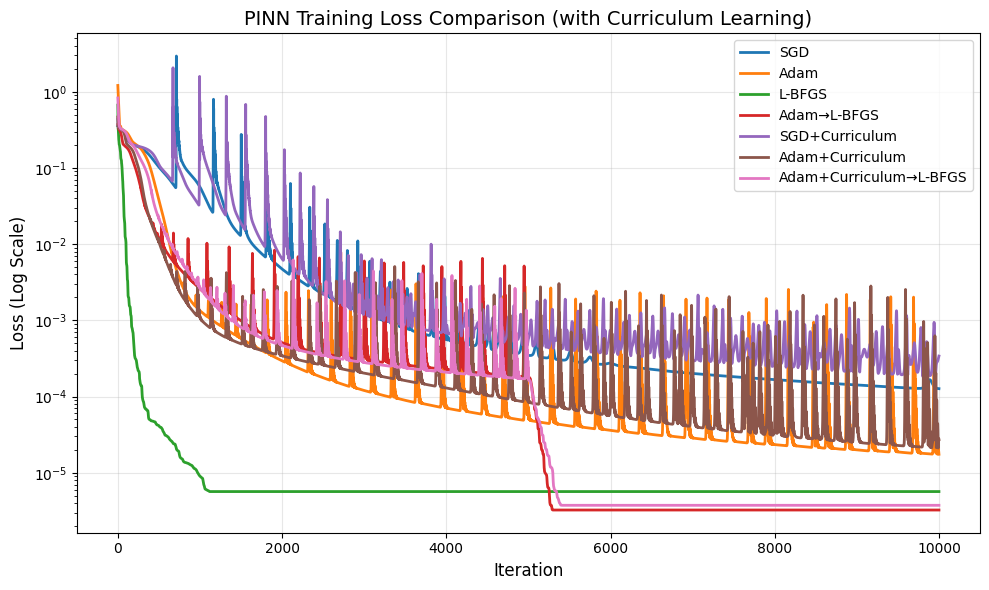

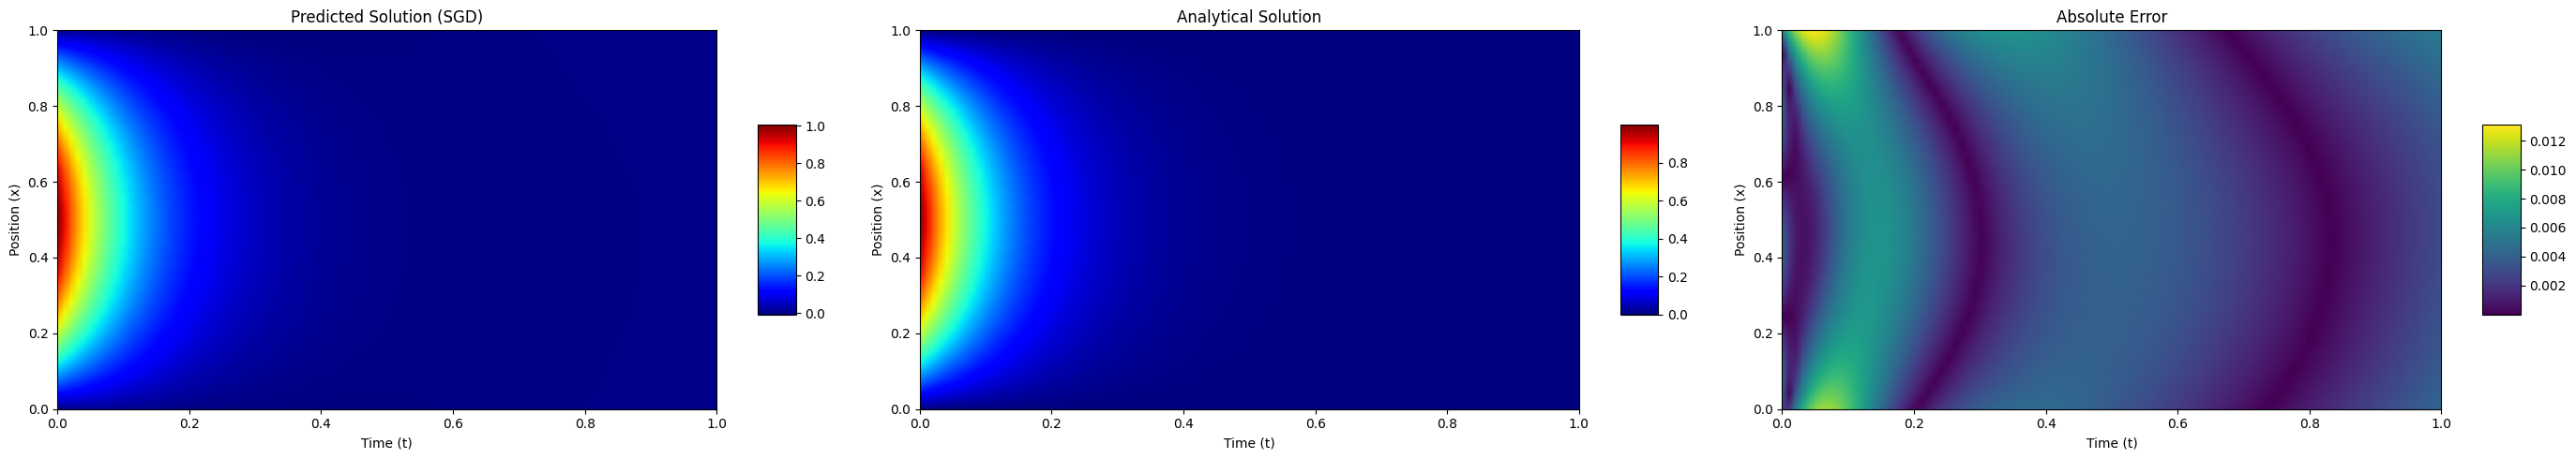

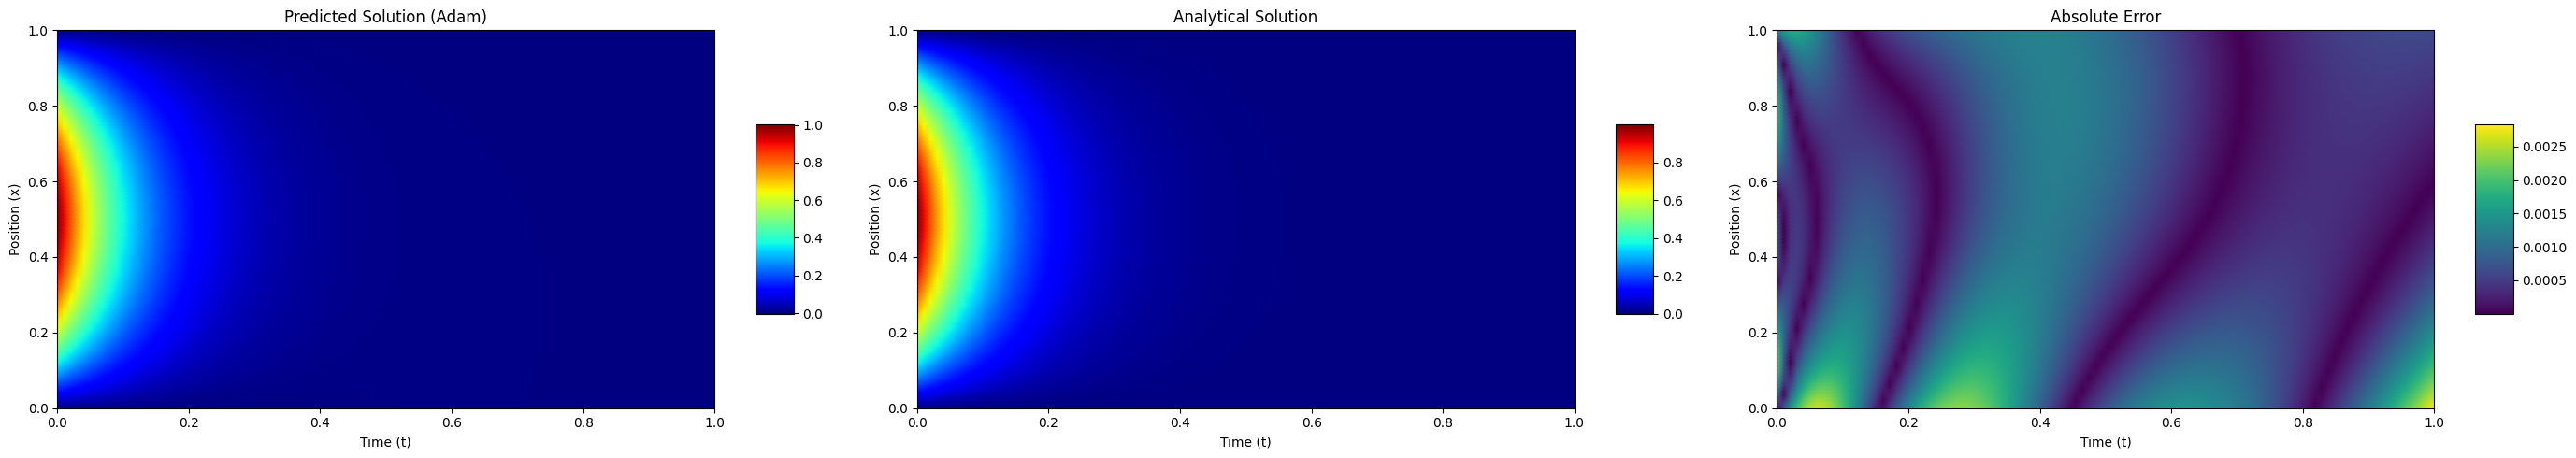

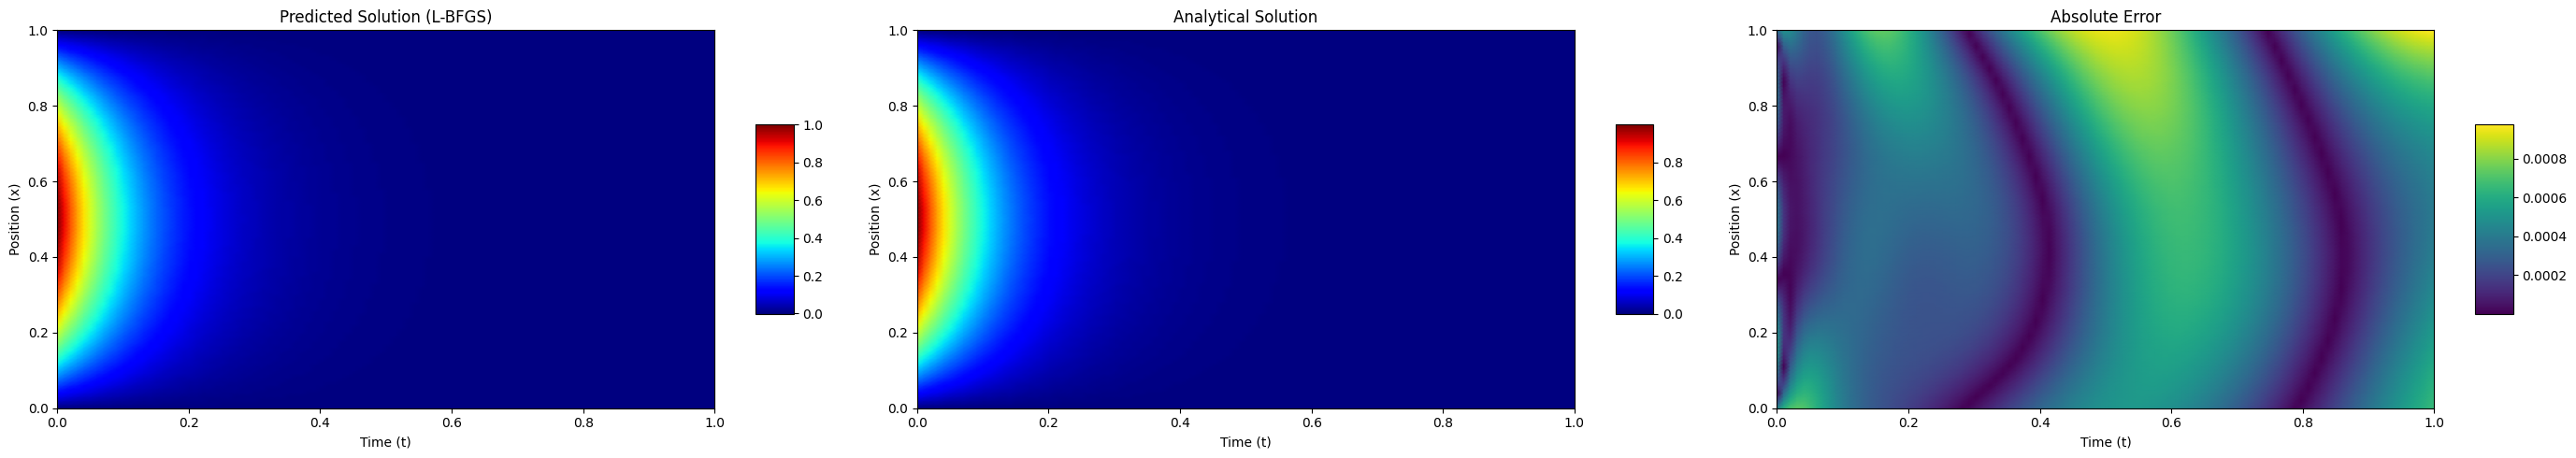

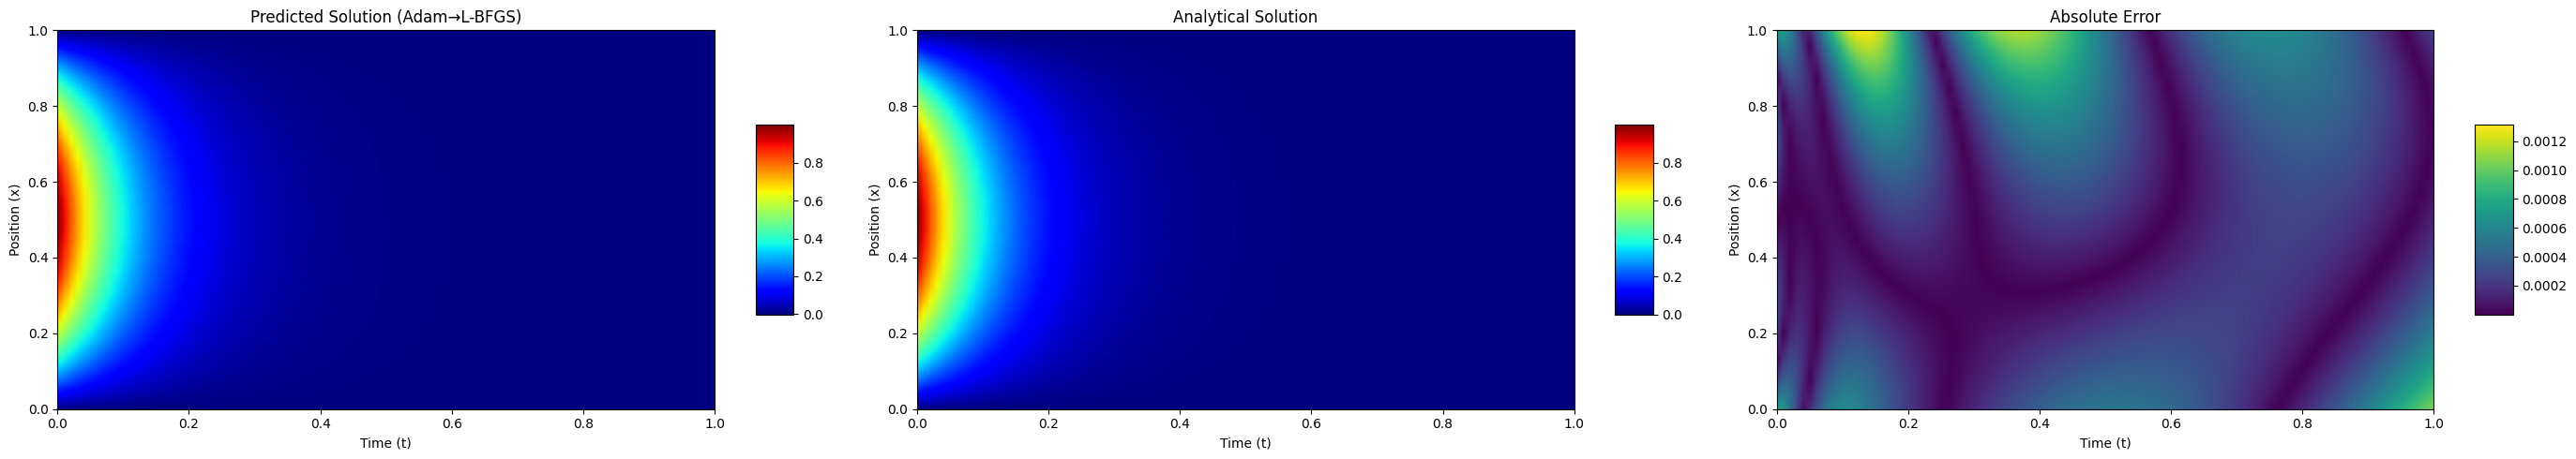

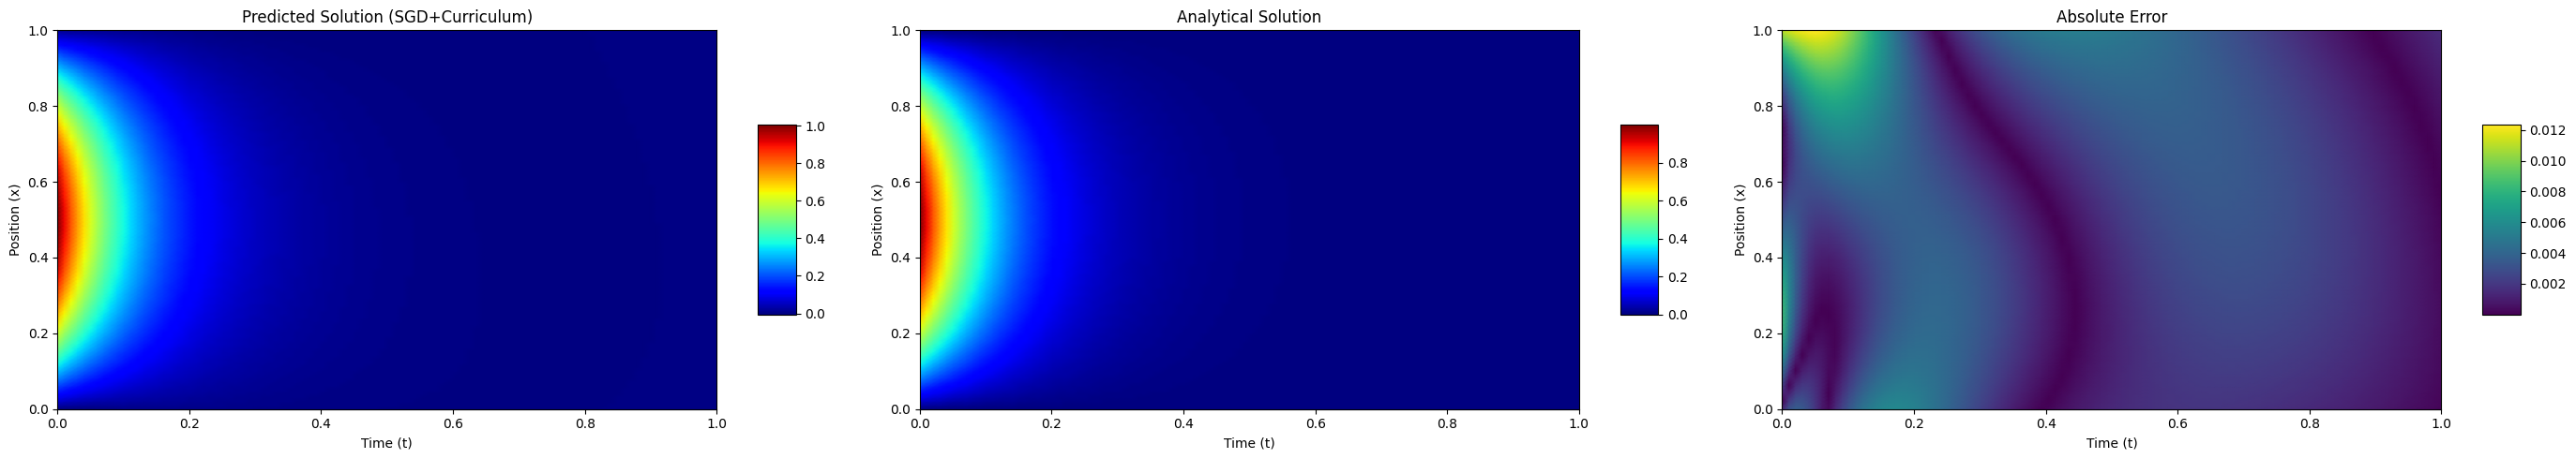

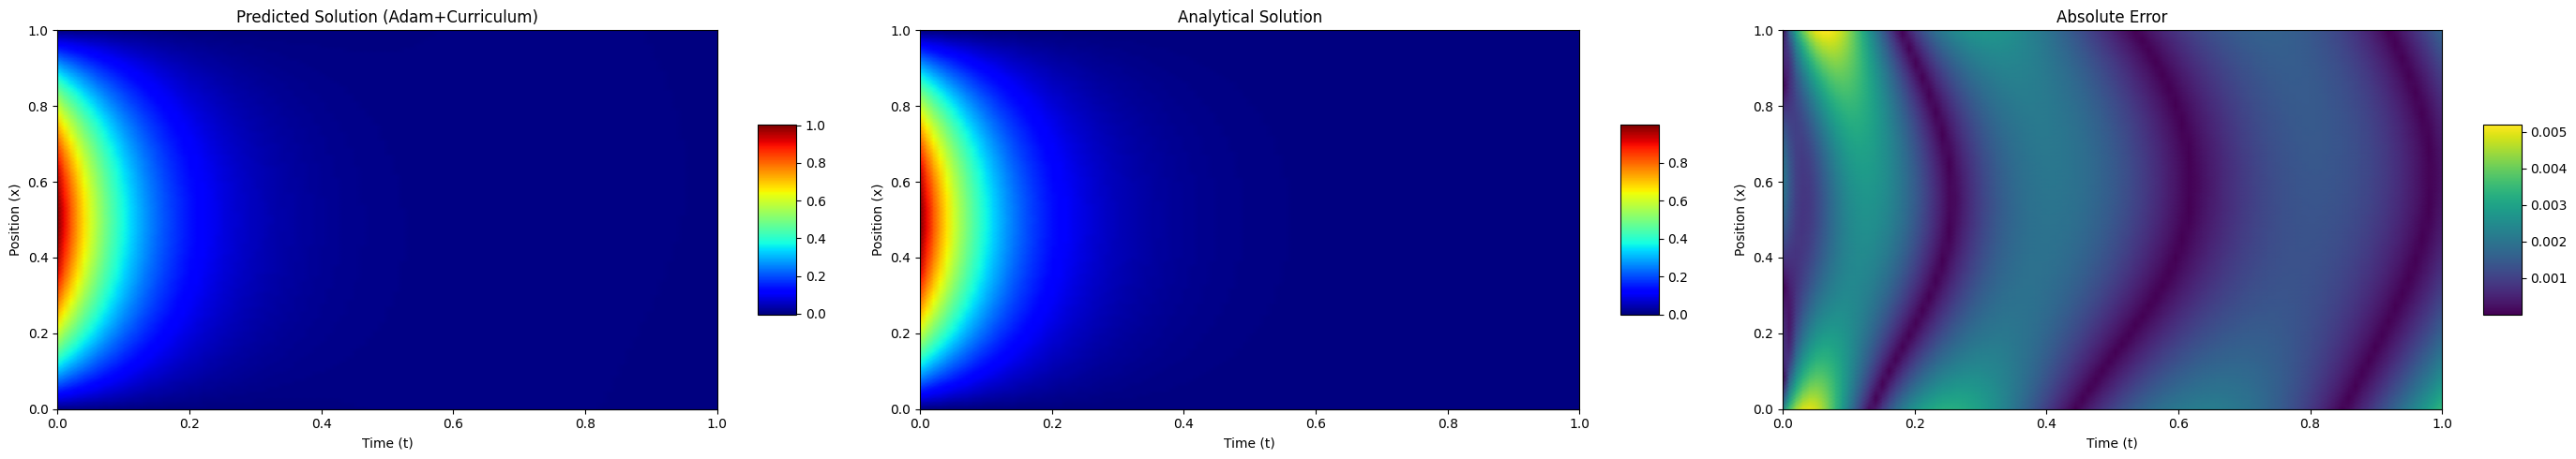

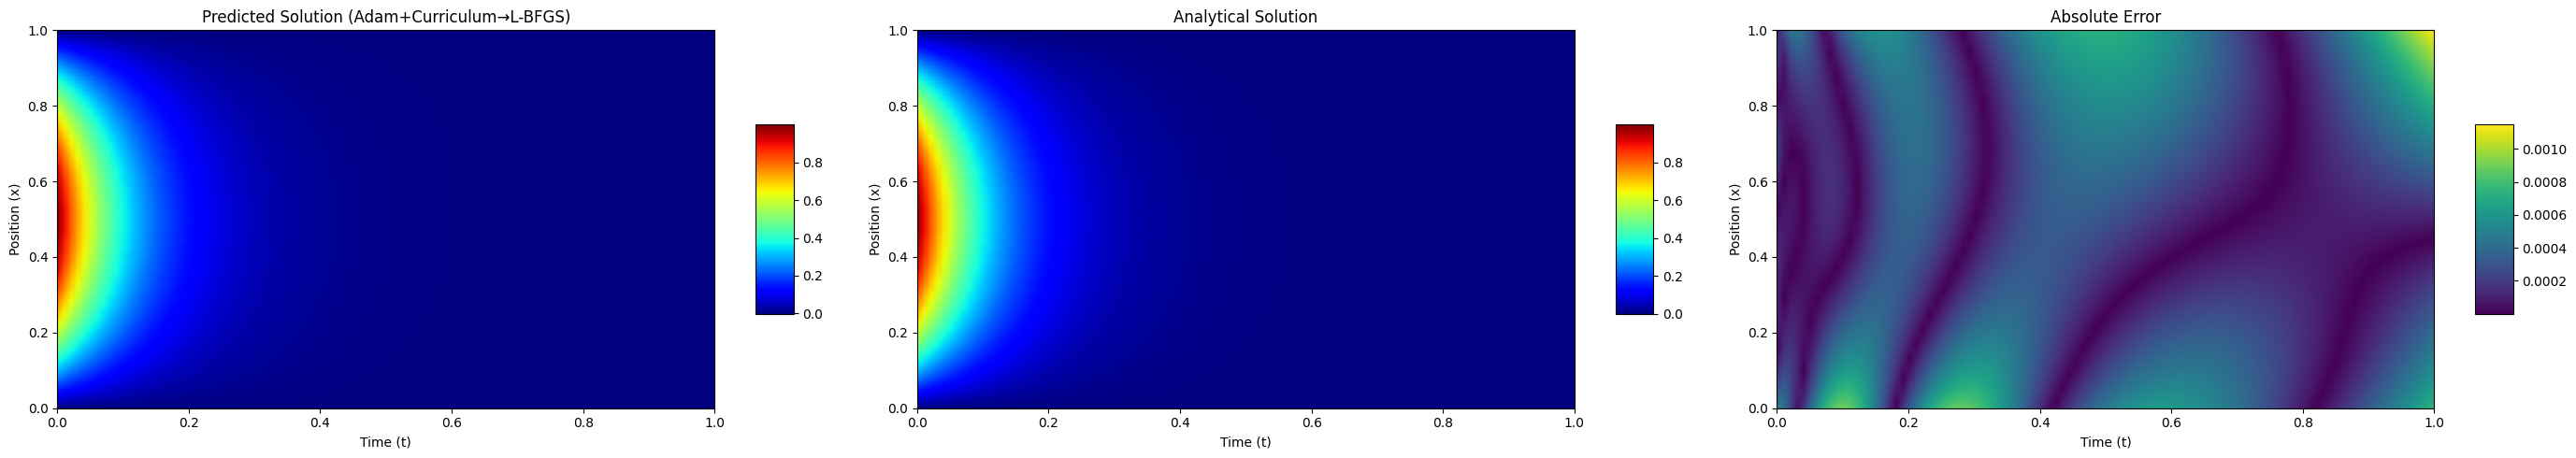


训练时间对比
SGD                       | 训练时间: 93.39 秒 (1.56 分钟)
Adam                      | 训练时间: 98.46 秒 (1.64 分钟)
L-BFGS                    | 训练时间: 998.28 秒 (16.64 分钟)
Adam→L-BFGS               | 训练时间: 85.18 秒 (1.42 分钟)
SGD+Curriculum            | 训练时间: 85.07 秒 (1.42 分钟)
Adam+Curriculum           | 训练时间: 152.35 秒 (2.54 分钟)
Adam+Curriculum→L-BFGS    | 训练时间: 155.69 秒 (2.59 分钟)

最终L2误差对比
SGD                       | L2 误差: 3.68e-03
Adam                      | L2 误差: 8.01e-04
L-BFGS                    | L2 误差: 4.15e-04
Adam→L-BFGS               | L2 误差: 3.42e-04
SGD+Curriculum            | L2 误差: 3.04e-03
Adam+Curriculum           | L2 误差: 1.55e-03
Adam+Curriculum→L-BFGS    | L2 误差: 3.24e-04


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm  
import matplotlib.pyplot as plt
import time

# 设置随机种子以保证结果可复现
torch.manual_seed(1224)
np.random.seed(1224)

# 1. 定义PINN模型
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(PINN, self).__init__()
        # 输入层
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        # 隐藏层，层数为 n_layers - 1
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        # 输出层
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)
    
    # 前向传播
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """前向传播：输入 x 和 t，输出预测值 u"""
        input_tensor = torch.cat([x, t], dim=1)  # 在列方向拼接 x 和 t
        for layer in self.layers:
            input_tensor = layer(input_tensor)
        return input_tensor

    # 计算偏导数的函数
    def compute_gradients(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """计算偏导数 u_t（对 t 的一阶偏导）、u_x（对 x 的一阶偏导）和 u_xx（对 x 的二阶偏导）"""
        u = self.forward(x, t)  # 预测值
        # 计算 u_t：对 t 的一阶偏导
        u_t = torch.autograd.grad(
            outputs=u,
            inputs=t,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        # 计算 u_x：对 x 的一阶偏导
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        # 计算 u_xx：对 x 的二阶偏导
        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=x,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        return u_t, u_xx

    # 定义PDE损失函数（返回总损失和单样本损失）
    def pde_loss(self, x: torch.Tensor, t: torch.Tensor, weights: torch.Tensor = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        PDE 损失：热方程 u_t - u_xx = 0
        返回：加权总损失 + 单样本残差（用于更新权重）
        """
        u_t, u_xx = self.compute_gradients(x, t)
        pde_residual = (u_t - u_xx) ** 2  # 单样本残差（平方）
        if weights is None:
            # 无权重时，等价于原损失
            total_loss = torch.mean(pde_residual)
        else:
            # 有权重时，加权平均（权重已归一化）
            total_loss = torch.mean(weights * pde_residual)
        return total_loss, pde_residual

    # 定义初始条件函数
    def initial_loss(self, x: torch.Tensor, t0: torch.Tensor) -> torch.Tensor:
        u_pred = self.forward(x, t0)
        u_exact = torch.sin(np.pi * x)
        return torch.mean((u_pred - u_exact) ** 2)
    
    # 定义边界条件函数
    def boundary_loss(self, t: torch.Tensor) -> torch.Tensor:
        x0 = torch.zeros_like(t)
        u0 = self.forward(x0, t)
        x1 = torch.ones_like(t)
        u1 = self.forward(x1, t)
        return torch.mean(u0 ** 2) + torch.mean(u1 ** 2)

# 2. 生成训练和测试数据
def generate_data(
    n_pde: int = 1000,
    n_initial: int = 200,
    n_boundary: int = 200,
    n_test: int = 100
) -> tuple:
    # PDE内部点：x ∈ [0,1], t ∈ [0,1]
    x_pde = torch.rand(n_pde, 1, requires_grad=True)
    t_pde = torch.rand(n_pde, 1, requires_grad=True)
    pde_data = (x_pde, t_pde)
    
    # 初始条件点：t=0, x ∈ [0,1]
    x_initial = torch.rand(n_initial, 1, requires_grad=True)
    t_initial = torch.zeros_like(x_initial, requires_grad=True)
    initial_data = (x_initial, t_initial)
    
    # 边界条件点：x=0 和 x=1, t ∈ [0,1]
    t_boundary = torch.rand(n_boundary, 1, requires_grad=True)
    boundary_data = t_boundary
    
    # 测试数据
    x_test = torch.linspace(0, 1, n_test).reshape(-1, 1)
    t_test = torch.linspace(0, 1, n_test).reshape(-1, 1)
    x_test_grid, t_test_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    x_test_flat = x_test_grid.reshape(-1, 1)
    t_test_flat = t_test_grid.reshape(-1, 1)
    test_data = (x_test_flat, t_test_flat)
    
    return pde_data, initial_data, boundary_data, test_data

# 3. 基础训练函数（适配Adam/SGD）
def train_with_optimizer(
    model: PINN,
    optimizer: optim.Optimizer,
    epochs: int,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list
) -> None:
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    t_boundary = boundary_data
    
    model.train()

    for epoch in range(epochs):
        pde_loss, _ = model.pde_loss(x_pde, t_pde)  # 忽略单样本残差
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        total_loss = pde_loss + initial_loss + boundary_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        loss_history.append(total_loss.item())
        
        if (epoch + 1) % 1000 == 0:
            print(
                f'轮数 {epoch+1:4d} | 总损失: {total_loss.item():.6f} | '
                f'PDE损失: {pde_loss.item():.6f} | 初始条件损失: {initial_loss.item():.6f} | '
                f'边界条件损失: {boundary_loss.item():.6f}'
            )

# 4. L-BFGS训练函数
def train_with_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    lr: float,
    max_iter: int
) -> None:
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    t_boundary = boundary_data
    
    model.train()
    pde_loss_val = initial_loss_val = boundary_loss_val = 0.0

    def closure() -> torch.Tensor:
        nonlocal pde_loss_val, initial_loss_val, boundary_loss_val
        optimizer.zero_grad()
        pde_loss, _ = model.pde_loss(x_pde, t_pde)
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        total_loss = pde_loss + initial_loss + boundary_loss
        total_loss.backward()
        
        pde_loss_val = pde_loss.item()
        initial_loss_val = initial_loss.item()
        boundary_loss_val = boundary_loss.item()

        return total_loss
    
    optimizer = optim.LBFGS(
        model.parameters(),
        max_iter=1,
        max_eval=10,
        line_search_fn='strong_wolfe',
        lr=lr
    )
    
    for iter_idx in range(max_iter):
        total_loss = optimizer.step(closure)
        current_loss = total_loss.item()
        loss_history.append(current_loss)
        
        if (iter_idx + 1) % 500 == 0 or iter_idx == 0:
            print(
                f'迭代 {iter_idx+1}/{max_iter} | 总损失: {current_loss:.6f} | '
                f'PDE损失: {pde_loss_val:.6f} | 初始条件损失: {initial_loss_val:.6f} | '
                f'边界条件损失: {boundary_loss_val:.6f}'
            )

# 5. 两阶段训练函数（Adam→L-BFGS）
def train_adam_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    adam_epochs: int,
    lr_lbfgs: float,
    lbfgs_max_iter: int
) -> None:
    """两阶段训练：先Adam全局探索，再L-BFGS局部精调"""
    print("\n=== 第一阶段：Adam全局探索 ===")
    # Adam优化器初始化
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    # 第一阶段：Adam训练
    train_with_optimizer(
        model=model,
        optimizer=optimizer_adam,
        epochs=adam_epochs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history
    )
    
    print("\n=== 第二阶段：L-BFGS局部精调 ===")
    # 第二阶段：L-BFGS训练（基于Adam的最终参数继续优化）
    train_with_lbfgs(
        model=model,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history,
        lr=lr_lbfgs,
        max_iter=lbfgs_max_iter
    )

# 6. 课程学习权重更新函数
def update_pde_weights(pde_residual: torch.Tensor, beta: float, prev_weights: torch.Tensor = None) -> torch.Tensor:
    """
    基于模型表现更新PDE样本权重：residual越大，权重越高
    公式：p_{t+1}(z) ∝ p_t(z) * exp(β * d_t(z))
    """
    n_samples = pde_residual.shape[0] # 样本数量
    # 初始轮次无权重时，用均匀分布初始化
    if prev_weights is None:
        prev_weights = torch.ones(n_samples, 1, device=pde_residual.device) / n_samples
    
    # 计算难度加权因子 exp(β * 残差)
    weight_factor = torch.exp(beta * pde_residual)
    # 计算新权重（未归一化）
    new_weights = prev_weights * weight_factor
    # 归一化：保证权重均值为1，避免数值不稳定
    new_weights = new_weights / torch.mean(new_weights)
    return new_weights

# 7. 带课程学习的训练函数(适配Adam/SGD)
def train_with_curriculum(
    model: PINN,
    optimizer: optim.Optimizer,
    epochs: int,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    beta: float = 0.08,  # 难度敏感系数
    weight_update_freq: int = 100  # 权重更新频率（每多少轮更新一次权重）
) -> None:
    """带课程学习的训练：根据PDE残差动态调整样本权重"""
    x_pde, t_pde = pde_data
    x_initial, t_initial = initial_data
    t_boundary = boundary_data
    
    model.train()
    pde_weights = None  # 初始权重为None（均匀分布）
    
    for epoch in range(epochs):
        # 1. 计算各部分损失
        # PDE损失（带权重）
        pde_loss, pde_residual = model.pde_loss(x_pde, t_pde, pde_weights)
        # 初始/边界损失（固定，不参与权重调整）
        initial_loss = model.initial_loss(x_initial, t_initial)
        boundary_loss = model.boundary_loss(t_boundary)
        # 总损失（保持原有的损失平衡）
        total_loss = pde_loss + initial_loss + boundary_loss
        
        # 2. 反向传播与参数更新
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # 3. 记录损失
        loss_history.append(total_loss.item())
        
        # 4. 定期更新PDE样本权重（每weight_update_freq轮）
        if (epoch + 1) % weight_update_freq == 0:
            pde_weights = update_pde_weights(pde_residual.detach(), beta, pde_weights)
            # 打印权重统计信息
            if (epoch + 1) % 1000 == 0:
                weight_mean = torch.mean(pde_weights).item()
                weight_max = torch.max(pde_weights).item()
                weight_min = torch.min(pde_weights).item()
                print(f'轮数 {epoch+1:4d} | 权重统计 - 均值: {weight_mean:.6f}, 最大: {weight_max:.6f}, 最小: {weight_min:.6f}')
        
        # 5. 打印训练进度
        if (epoch + 1) % 1000 == 0:
            print(
                f'轮数 {epoch+1:4d} | 总损失: {total_loss.item():.6f} | '
                f'PDE损失: {pde_loss.item():.6f} | 初始条件损失: {initial_loss.item():.6f} | '
                f'边界条件损失: {boundary_loss.item():.6f}'
            )

# 8. 两阶段训练函数（Adam+课程学习→L-BFGS）
def train_adam_curriculum_lbfgs(
    model: PINN,
    pde_data: tuple,
    initial_data: tuple,
    boundary_data: torch.Tensor,
    loss_history: list,
    adam_epochs: int,
    lr_lbfgs: float,
    lbfgs_max_iter: int,
    beta: float = 0.1,
    weight_update_freq: int = 100
) -> None:
    """三阶段训练：Adam+课程学习（全局探索）→ L-BFGS（局部精调）"""
    print("\n=== 第一阶段：Adam+课程学习全局探索 ===")
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
    train_with_curriculum(
        model=model,
        optimizer=optimizer_adam,
        epochs=adam_epochs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history,
        beta=beta,
        weight_update_freq=weight_update_freq
    )
    
    print("\n=== 第二阶段：L-BFGS局部精调 ===")
    train_with_lbfgs(
        model=model,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history,
        lr=lr_lbfgs,
        max_iter=lbfgs_max_iter
    )

# 9. 评估函数和可视化函数
def evaluate_model(
    model: PINN,
    test_data: tuple,
    u_exact: torch.Tensor
) -> tuple[float, np.ndarray, np.ndarray]:
    x_test, t_test = test_data
    model.eval()
    with torch.no_grad():
        u_pred = model(x_test, t_test)
    l2_error = torch.sqrt(torch.mean((u_pred - u_exact) ** 2)).item()
    pointwise_error = torch.abs(u_pred - u_exact).numpy()
    u_pred_np = u_pred.numpy()
    return l2_error, pointwise_error, u_pred_np

def plot_loss_curves(loss_histories: list, labels: list, title: str = 'Training Loss Comparison') -> None:
    plt.figure(figsize=(10, 6))
    for loss_history, label in zip(loss_histories, labels):
        plt.plot(loss_history, label=label, linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.yscale('log')
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_solution_comparison_2d(
    test_data: tuple,
    u_pred: np.ndarray,
    u_exact_np: np.ndarray,
    title: str
) -> None:
    x_test, t_test = test_data
    n_test = int(np.sqrt(len(x_test)))
    x_grid = x_test.reshape(n_test, n_test)
    t_grid = t_test.reshape(n_test, n_test)
    u_pred_grid = u_pred.reshape(n_test, n_test)
    u_exact_grid = u_exact_np.reshape(n_test, n_test)
    error_grid = np.abs(u_pred_grid - u_exact_grid)
    
    fig = plt.figure(figsize=(28, 5))
    # 预测解
    ax1 = fig.add_subplot(131)
    im1 = ax1.pcolormesh(t_grid, x_grid, u_pred_grid, cmap=cm.jet, shading='gouraud')
    ax1.set_xlabel('Time (t)', fontsize=10)
    ax1.set_ylabel('Position (x)', fontsize=10)
    ax1.set_title(f'Predicted Solution ({title})', fontsize=12)
    fig.colorbar(im1, ax=ax1, shrink=0.5, aspect=5)
    
    # 精确解
    ax2 = fig.add_subplot(132)
    im2 = ax2.pcolormesh(t_grid, x_grid, u_exact_grid, cmap=cm.jet, shading='gouraud')
    ax2.set_xlabel('Time (t)', fontsize=10)
    ax2.set_ylabel('Position (x)', fontsize=10)
    ax2.set_title('Analytical Solution', fontsize=12)
    fig.colorbar(im2, ax=ax2, shrink=0.5, aspect=5)
    
    # 绝对误差
    ax3 = fig.add_subplot(133)
    im3 = ax3.pcolormesh(t_grid, x_grid, error_grid, cmap=cm.viridis, shading='gouraud')
    ax3.set_xlabel('Time (t)', fontsize=10)
    ax3.set_ylabel('Position (x)', fontsize=10)
    ax3.set_title('Absolute Error', fontsize=12)
    fig.colorbar(im3, ax=ax3, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

# 10. 主函数
def train_1D_heat_PINN_with_curriculum():
    # 1. 超参数设置
    n_layers = 4
    input_dim = 2
    output_dim = 1
    hidden_dim = 20
    n_pde = 1000
    n_initial = 200
    n_boundary = 200
    n_test = 100
    epochs_sgd_adam = 10000
    lr_lbfgs = 1.0
    lr_adam_lbfgs = 0.8
    max_iter_lbfgs = 10000
    adam_lbfgs_adam_epochs = 5000
    adam_lbfgs_lbfgs_iter = 5000
    
    # 课程学习参数
    curriculum_beta = 0.08  # 难度敏感系数（越大，难样本权重提升越明显）
    weight_update_freq = 100  # 每100轮更新一次PDE样本权重
    
    # 2. 生成数据
    pde_data, initial_data, boundary_data, test_data = generate_data(
        n_pde=n_pde,
        n_initial=n_initial,
        n_boundary=n_boundary,
        n_test=n_test
    )
    x_test, t_test = test_data
    u_exact = torch.exp(-np.pi**2 * t_test) * torch.sin(np.pi * x_test)
    u_exact_np = u_exact.numpy()
    
    # 3. 初始化存储变量（新增课程学习模型的记录）
    loss_histories = []
    l2_errors = []
    u_preds = []
    optim_labels = ['SGD', 'Adam', 'L-BFGS', 'Adam→L-BFGS', 'SGD+Curriculum', 'Adam+Curriculum', 'Adam+Curriculum→L-BFGS']
    training_times = []

    # 4. 原有模型训练
    # 4.1 SGD
    print("\n" + "="*50)
    print("使用SGD训练")
    print("="*50)
    model_sgd = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)
    loss_history_sgd = []
    start_time_sgd = time.time()
    train_with_optimizer(
        model=model_sgd,
        optimizer=optimizer_sgd,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_sgd
    )
    end_time_sgd = time.time()
    training_time_sgd = end_time_sgd - start_time_sgd
    training_times.append(training_time_sgd)
    print(f"SGD训练时间: {training_time_sgd:.2f} 秒 ({training_time_sgd/60:.2f} 分钟)")
    l2_error_sgd, _, u_pred_sgd = evaluate_model(model_sgd, test_data, u_exact)
    loss_histories.append(loss_history_sgd)
    l2_errors.append(l2_error_sgd)
    u_preds.append(u_pred_sgd)
    print(f"SGD L2 误差: {l2_error_sgd:.2e}")
    
    # 4.2 Adam
    print("\n" + "="*50)
    print("使用Adam训练")
    print("="*50)
    model_adam = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
    loss_history_adam = []
    start_time_adam = time.time()
    train_with_optimizer(
        model=model_adam,
        optimizer=optimizer_adam,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam
    )
    end_time_adam = time.time()
    training_time_adam = end_time_adam - start_time_adam
    training_times.append(training_time_adam)
    print(f"Adam训练时间: {training_time_adam:.2f} 秒 ({training_time_adam/60:.2f} 分钟)")
    l2_error_adam, _, u_pred_adam = evaluate_model(model_adam, test_data, u_exact)
    loss_histories.append(loss_history_adam)
    l2_errors.append(l2_error_adam)
    u_preds.append(u_pred_adam)
    print(f"Adam L2 误差: {l2_error_adam:.2e}")
    
    # 4.3 L-BFGS
    print("\n" + "="*50)
    print("使用L-BFGS训练")
    print("="*50)
    model_lbfgs = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_lbfgs = []
    start_time_lbfgs = time.time()
    train_with_lbfgs(
        model=model_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_lbfgs,
        lr=lr_lbfgs,
        max_iter=max_iter_lbfgs
    )
    end_time_lbfgs = time.time()
    training_time_lbfgs = end_time_lbfgs - start_time_lbfgs
    training_times.append(training_time_lbfgs)
    print(f"L-BFGS训练时间: {training_time_lbfgs:.2f} 秒 ({training_time_lbfgs/60:.2f} 分钟)")
    l2_error_lbfgs, _, u_pred_lbfgs = evaluate_model(model_lbfgs, test_data, u_exact)
    loss_histories.append(loss_history_lbfgs)
    l2_errors.append(l2_error_lbfgs)
    u_preds.append(u_pred_lbfgs)
    print(f"L-BFGS L2 误差: {l2_error_lbfgs:.2e}")
    
    # 4.4 Adam→L-BFGS
    print("\n" + "="*50)
    print("使用Adam→L-BFGS两阶段训练")
    print("="*50)
    model_adam_lbfgs = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_adam_lbfgs = []
    start_time_adam_lbfgs = time.time()
    train_adam_lbfgs(
        model=model_adam_lbfgs,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam_lbfgs,
        lr_lbfgs=lr_adam_lbfgs,
        adam_epochs=adam_lbfgs_adam_epochs,
        lbfgs_max_iter=adam_lbfgs_lbfgs_iter
    )
    end_time_adam_lbfgs = time.time()
    training_time_adam_lbfgs = end_time_adam_lbfgs - start_time_adam_lbfgs
    training_times.append(training_time_adam_lbfgs)
    print(f"Adam→L-BFGS训练时间: {training_time_adam_lbfgs:.2f} 秒 ({training_time_adam_lbfgs/60:.2f} 分钟)")
    l2_error_adam_lbfgs, _, u_pred_adam_lbfgs = evaluate_model(model_adam_lbfgs, test_data, u_exact)
    loss_histories.append(loss_history_adam_lbfgs)
    l2_errors.append(l2_error_adam_lbfgs)
    u_preds.append(u_pred_adam_lbfgs)
    print(f"Adam→L-BFGS L2 误差: {l2_error_adam_lbfgs:.2e}")
    
    # 5. SGD+课程学习训练
    print("\n" + "="*50)
    print("使用SGD+课程学习训练")
    print("="*50)
    model_sgd_curriculum = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_sgd_curriculum = optim.SGD(model_sgd_curriculum.parameters(), lr=0.01, momentum=0.9)
    loss_history_sgd_curriculum = []
    start_time_sgd_curriculum = time.time()
    train_with_curriculum(
        model=model_sgd_curriculum,
        optimizer=optimizer_sgd_curriculum,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_sgd_curriculum,
        beta=curriculum_beta,
        weight_update_freq=weight_update_freq
    )
    end_time_sgd_curriculum = time.time()
    training_time_sgd_curriculum = end_time_sgd_curriculum - start_time_sgd_curriculum
    training_times.append(training_time_sgd_curriculum)
    print(f"SGD+课程学习训练时间: {training_time_sgd_curriculum:.2f} 秒 ({training_time_sgd_curriculum/60:.2f} 分钟)")
    l2_error_sgd_curriculum, _, u_pred_sgd_curriculum = evaluate_model(model_sgd_curriculum, test_data, u_exact)
    loss_histories.append(loss_history_sgd_curriculum)
    l2_errors.append(l2_error_sgd_curriculum)
    u_preds.append(u_pred_sgd_curriculum)
    print(f"SGD+课程学习 L2 误差: {l2_error_sgd_curriculum:.2e}")

    # 6. Adam+课程学习训练
    print("\n" + "="*50)
    print("使用Adam+课程学习训练")
    print("="*50)
    model_adam_curriculum = PINN(input_dim, output_dim, hidden_dim, n_layers)
    optimizer_adam_curriculum = optim.Adam(model_adam_curriculum.parameters(), lr=0.001)
    loss_history_adam_curriculum = []
    start_time_adam_curriculum = time.time()    
    train_with_curriculum(
        model=model_adam_curriculum,
        optimizer=optimizer_adam_curriculum,
        epochs=epochs_sgd_adam,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_adam_curriculum,
        beta=curriculum_beta,
        weight_update_freq=weight_update_freq
    )
    end_time_adam_curriculum = time.time()
    training_time_adam_curriculum = end_time_adam_curriculum - start_time_adam_curriculum
    training_times.append(training_time_adam_curriculum)    
    print(f"Adam+课程学习训练时间: {training_time_adam_curriculum:.2f} 秒 ({training_time_adam_curriculum/60:.2f} 分钟)")
    l2_error_adam_curriculum, _, u_pred_adam_curriculum = evaluate_model(model_adam_curriculum, test_data, u_exact)
    loss_histories.append(loss_history_adam_curriculum)
    l2_errors.append(l2_error_adam_curriculum)
    u_preds.append(u_pred_adam_curriculum)
    print(f"Adam+课程学习 L2 误差: {l2_error_adam_curriculum:.2e}")

    # 7. Adam+课程学习→L-BFGS训练
    print("\n" + "="*50)
    print("使用Adam+课程学习→L-BFGS训练")
    print("="*50)
    model_curriculum = PINN(input_dim, output_dim, hidden_dim, n_layers)
    loss_history_curriculum = []
    start_time_curriculum = time.time()
    train_adam_curriculum_lbfgs(
        model=model_curriculum,
        pde_data=pde_data,
        initial_data=initial_data,
        boundary_data=boundary_data,
        loss_history=loss_history_curriculum,
        adam_epochs=adam_lbfgs_adam_epochs,
        lr_lbfgs=lr_adam_lbfgs,
        lbfgs_max_iter=adam_lbfgs_lbfgs_iter,
        beta=curriculum_beta,
        weight_update_freq=weight_update_freq
    )
    end_time_curriculum = time.time()
    training_time_curriculum = end_time_curriculum - start_time_curriculum
    training_times.append(training_time_curriculum)
    print(f"Adam+课程学习→L-BFGS训练时间: {training_time_curriculum:.2f} 秒 ({training_time_curriculum/60:.2f} 分钟)")
    l2_error_curriculum, _, u_pred_curriculum = evaluate_model(model_curriculum, test_data, u_exact)
    loss_histories.append(loss_history_curriculum)
    l2_errors.append(l2_error_curriculum)
    u_preds.append(u_pred_curriculum)
    print(f"Adam+课程学习→L-BFGS L2 误差: {l2_error_curriculum:.2e}")
    
    # 6. 结果可视化与对比
    plot_loss_curves(loss_histories, optim_labels, title='PINN Training Loss Comparison (with Curriculum Learning)')
    
    for i, (u_pred, label) in enumerate(zip(u_preds, optim_labels)):
        plot_solution_comparison_2d(test_data, u_pred, u_exact_np, title=label)
    
    # 训练时间对比
    print("\n" + "="*50)
    print("训练时间对比")
    print("="*50)
    for label, time_sec in zip(optim_labels, training_times):
        print(f"{label:25s} | 训练时间: {time_sec:.2f} 秒 ({time_sec/60:.2f} 分钟)")
    
    # L2误差对比
    print("\n" + "="*50)
    print("最终L2误差对比")
    print("="*50)
    for label, error in zip(optim_labels, l2_errors):
        print(f"{label:25s} | L2 误差: {error:.2e}")

# 执行主函数
train_1D_heat_PINN_with_curriculum()